# Russian Movie Reviews Classificator Report
##  I. Dataset Presentation
We start our report with presentation of the dataset that we've collected for this task. 
The dataset is contained in the file "russian-reviews.json". We can access it by importing a special python module that we've created:

In [1]:
import ru_otzyv as ru

This module contains important functions like `crawl`, `save`, `load` and `update` that are dedicated to maintain the dataset. You can refer to the file `ru_crawler.py` to get more information on these functions.

We collected this dataset by scraping all the reviews from the russian web-site http://kino.otzyv.ru (hence the name). You can read recent reviews by visiting: http://kino.otzyv.ru/last.php

Nice thing about this site is that the HTML structure of the review page is not very complicated, so we've build a python crawler that can parse it. Almost every review has a rating mark from 1 to 10, which makes it a perfect place to gather data.

Firstly we need to update and save the dataset, because now new reviews have been submitted. Just issue:

In [2]:
dataset_filename = 'ru-reviews.json'
data_dict = ru.load(dataset_filename)
data_dict = ru.update(data_dict)
ru.save(data_dict, dataset_filename)

Updating provided dictionary...
Start scraping 11 reviews with id from 70819 to 70830.
+2 reviews, up next: 70820
Speed: 8.12 reviews/second; Elapsed: 0.00 m; Remained: 0.02 m
Status: [=========                                                                                           ] 9%

+2 reviews, up next: 70822
Speed: 8.78 reviews/second; Elapsed: 0.01 m; Remained: 0.02 m
Status: [===========================                                                                         ] 27%

+2 reviews, up next: 70824
Speed: 8.21 reviews/second; Elapsed: 0.01 m; Remained: 0.01 m
Status: [=============================================                                                       ] 45%

+2 reviews, up next: 70826
Speed: 8.76 reviews/second; Elapsed: 0.02 m; Remained: 0.01 m
Status: [================================================================                                    ] 64%

+2 reviews, up next: 70828
Speed: 8.70 reviews/second; Elapsed: 0.02 m; Remained: 0.00 m
Statu

If you got an error, make sure that the file `russin-reviews.json` is in the same directory as this jupyter notebook.

Now we can take a look at the data:

In [3]:
index = 7
data_dict[str(index)]

['Мало в каких фильмах так воссоздается атмосфера, в которую погружаешся полностью и никакого нет желания отуда выходить. Жизнь может быть прекрасна - если только захотеть.  При этом твоя профессия и заработки никакого значения не имеют. Важны только люди, их чувства и отношения.',
 '10']

The result is a tuple of two elements: a review string and a rating mark. You can play around with `index`, just keep in mind that type of keys is `string`, not `int`. Also, some reviews don't have rating, in this case you will see the value `-1`:

In [4]:
data_dict['12']

['Как можно было так испоганить книжку?', -1]

Let's look at some characteristics of our dataset to get better feelings about its' quality. Firstly notice its lenght:

In [5]:
len(data_dict)

70830

More that 70 thousands entries! Now let's show how many reviews each rating mark has:

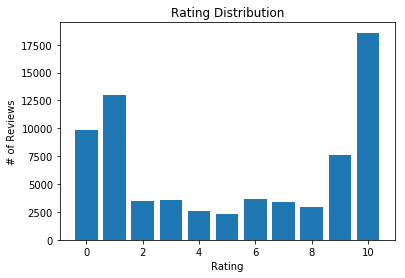

In [6]:
ru.rating_distribution(data_dict)

As we can see, users of the site `otzyv.ru` tend to assign either high or low rating mark to films. First bar with 0 rating indicates reviews that don't have a mark. Unfortunately, these entries need be removed, because they cannot serve as a train or test data.

How about the average length of the review for each rating? Run: 

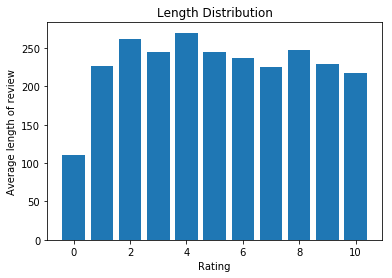

In [7]:
ru.length_distribution(data_dict)

This plot shows us that the average length of a review is approximately 225 symbols. Notice that reviews without a rating mark have significantly shorter length (~ 110 symbols).

Now, when we have better understanding of our dataset, it's time to prepare the model.
## II. LSTM Implementation.
Our dataset is still not prepared for supplying into LSTM.
In order to rectify that we need to perform the following steps:
    1. Remove all entries with no rating.
    2. Tokenize all reviews:
        2.1. Split by space.
        2.2. Remove all junky symbols.
        2.3. Lowercase and stem all tokens.
    3. Build a vocabulary of tokens and sort it by their frequency.
    4. Replace each token in every review by its frequncy index.
    5. If the number of reviews with and negative ratings is uneven, then equalize it by duplicating minor samples.
    6. Split the data into train and test halfs.
In the result we obtain the dataset with the same format as the IMDB in the `keras.datasets` module. The function `cook_data()` in the module `ru_otzyv` executes these steps and return the data that is ready to be feeded into LSTM:

In [8]:
# Get the data...
top_words = 10000 + 1
x_train, y_train, x_test, y_test = ru.cook_data(topn=top_words, update_vocab=True)
# Test for equality...
nb_positive = len([i for i in y_train + y_test if i == 1])
l = len(y_train + y_test)
print("Number of reviews:%d\nPositive reviews:%s%%" % l, nb_positive / l * 100)

KeyboardInterrupt: 

As we can see, now all data is completely normalized. Also notice that we decided to keep only first 5'000 words from the top. 

Once we have the data, next steps in building LSTM will be the same as for the IMDB dataset, but with only the following differences:
    1. Now we use `Dropout` techique to increase the learning speed and avoid overfitting. This step alone allowed us to gain 83.07% of accuracy.
    2. We split the train and test data in 70%/30% proportion.
To compile and train the model we need to run the following code. 
Keep in mind that it takes some time to execute 5 epoches on 2 LSTM, even with dropout.

We wrote a module `russian-classifier.py` that has the actual implementation of our model. For the sake of simplicity, this module contains a function `build_and_evaluate` which does everything in one shot: prepares the data, compiles, trains and evaluates the LSTM:

In [10]:
import russian_classifier as ru_classifier
our_lstm = ru_classifier.build_and_evaluate()

Preparing the dataset...
Dataset preparation complete!
Compiling the model...


/Users/outofbound/Documents/Spring 2016/NLP/Assignments/2/russian_classifier.py:37: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, dropout=0.2, recurrent_dropout=0.2)`
  model.add(LSTM(100, dropout_W=d, dropout_U=d))


Mode compilation complete!
Training the model...
Epoch 1/5


InvalidArgumentError: indices[0,294] = 7569 is not in [0, 5001)
	 [[Node: embedding_1/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_1/embeddings/read, _recv_embedding_1_input_0)]]

Caused by op 'embedding_1/Gather', defined at:
  File "<string>", line 1, in <module>
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/ipykernel/kernelapp.py", line 484, in main
    app.start()
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/outofbound/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-f2dc3b1c1676>", line 1, in <module>
    import russian_classifier as ru_classifier
  File "<frozen importlib._bootstrap>", line 961, in _find_and_load
  File "<frozen importlib._bootstrap>", line 950, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 655, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 205, in _call_with_frames_removed
  File "/Users/outofbound/Documents/Spring 2016/NLP/Assignments/2/russian_classifier.py", line 130, in <module>
    my_lstm = build_and_evaluate()
  File "/Users/outofbound/Documents/Spring 2016/NLP/Assignments/2/russian_classifier.py", line 95, in build_and_evaluate
    my_lstm = compile_model()
  File "/Users/outofbound/Documents/Spring 2016/NLP/Assignments/2/russian_classifier.py", line 35, in compile_model
    model.add(Embedding(params['top_words'], params['embedding_vector_length'], input_length=params['max_review_length']))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/models.py", line 422, in add
    layer(x)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/topology.py", line 554, in __call__
    output = self.call(inputs, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/layers/embeddings.py", line 119, in call
    out = K.gather(self.embeddings, inputs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 966, in gather
    return tf.gather(reference, indices)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1359, in gather
    validate_indices=validate_indices, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): indices[0,294] = 7569 is not in [0, 5001)
	 [[Node: embedding_1/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_1/embeddings/read, _recv_embedding_1_input_0)]]


We can look at the overall performance of our model through time on the two previous plots. As we can see it's close to desired 92%. 

## III. Model Presentation
Finally, it's time to put our creation in the wild: let's test our fresh LSTM on the real data. We've prepared two high quality russian reviews, one positive and one negative. Use the function `predict` from the module `russian_classifier`:

In [ ]:
filename = 'positive0.txt'
predicted_rating = ru_classifier.predict(our_lstm, filename)
print(predicted_rating)
filename = 'negative0.txt'
predicted_rating = ru_classifier.predict(our_lstm,  filename)
print(predicted_rating)

As we can see, computer successfully predicted the right movie rating. You can now play around with our model, supplying to it different review files. This concludes our report on the last part of the assignment.